# Force Optimizations Data Analysis 

## Ensemble of Optimizations

In [1]:
from optimization_tools import *
from analysis_tools import *
import matplotlib
import matplotlib.pyplot as plt
import os

DESC version 0.11.1,using JAX backend, jax version=0.4.30, jaxlib version=0.4.30, dtype=float64
Using device: CPU, with 15.60 GB available memory


### Initial Optimizations
First, we perform our initial optimizations using the random (educated) guesses for the weights on the objective function. As these optimizations demand significant computational resources, the code is commented out for the purpose of this example. 

In [2]:
# initial_optimizations()

We next analyze our set of optimizations and parse the data into three DataFrames: `df`, representing the full set of optimizations; `df_filtered`, representing the set of optimizations that passed pre-specified filtering criteria; and `df_pareto1`, representing the set of optimizations on the Pareto front. (This method also exports the Universally Unique Identifiers (unique identifiers for each optimization) of the Pareto front to 
`pareto.txt`). 

In [3]:
df, df_filtered, df_pareto = get_dfs()

Let's take a look at our optimizations!

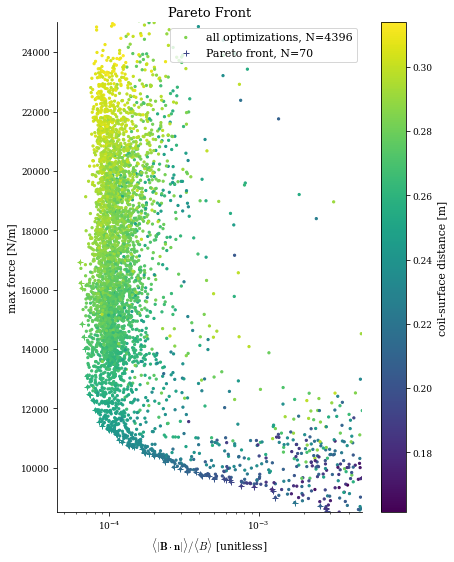

In [4]:
fig = plt.figure(figsize=(6.5, 8))
plt.rc("font", size=13)
markersize = 5
n_pareto = df_pareto.shape[0]
n_filtered = df_filtered.shape[0] - n_pareto
color="coil_surface_distance"
color_label="coil-surface distance [m]"
norm = plt.Normalize(min(df_filtered[color]), max(df_filtered[color]))
plt.scatter(
    df_filtered["normalized_BdotN"],
    df_filtered["max_max_force"],
    c=df_filtered[color],
    s=markersize,
    label=f'all optimizations, N={n_filtered}',
    norm=norm
)
plt.scatter(
    df_pareto["normalized_BdotN"], 
    df_pareto["max_max_force"], 
    c=df_pareto[color], 
    marker="+",
    label=f'Pareto front, N={n_pareto}',
    norm=norm,
)
plt.xlabel(r'$\langle|\mathbf{B}\cdot\mathbf{n}|\rangle/\langle B \rangle$ [unitless]')
plt.ylabel("max force [N/m]")
plt.xlim(0.7 * min(df_filtered["normalized_BdotN"]), max(df_filtered["normalized_BdotN"]))
plt.ylim(8500, 25000)
plt.xscale("log")
plt.colorbar(label=color_label)
plt.legend(loc='upper right', fontsize='11')
plt.title('Pareto Front')
plt.show()

### Continuation Method
Now, let us perform the first iteration of our continuation method. Here, we perform the first iteration and allow the maximum variation in any parameter to be a randomly chosen number in the range $10^{-3}$ to $5\times 10^{-2}$. From this point, it is possible to perform the $i+1$-th iteration of the continuation method by using the $i$-th Pareto fronts as input.

In [5]:
# for i in range(1000): continuation(N=1, dx = 10**rand(-3, -1.3))

If desired, we can also export the Pareto fronts unique folders for easy access. This is helpful for high-performance computing calculations, in which one wishes to reduce the number of files stored on the system.

In [16]:
# for folder in os.listdir("./output/QA/"):
#     f = os.path.join("./output/QA/", folder)
#     if not os.path.isfile(f)
#         get_dfs(INPUT_DIR = f"{f}/optimizations/", OUTPUT_DIR=f"{f}/pareto/")

Now, let us see how performing the continuation method impacts our Pareto fronts. 

/var/folders/qx/zl9pfmpn3yz5f62mt03d1m5w0000gs/T/ipykernel_45285/961663027.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  norm = plt.Normalize(1, np.sum(os.path.isdir(os.path.join("./output/QA/", f)) for f in os.listdir("./output/QA/")))


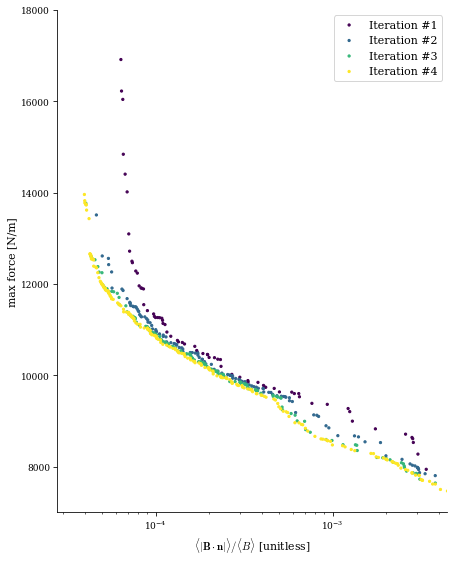

In [7]:
fig = plt.figure(figsize=(6.5, 8))
norm = plt.Normalize(1, np.sum(os.path.isdir(os.path.join("./output/QA/", f)) for f in os.listdir("./output/QA/")))
plt.rc("font", size=13)
for filename in sorted(os.listdir("./output/QA/")):
    f = os.path.join("./output/QA/", filename)
    if os.path.isdir(f):
        *_, df = get_dfs(INPUT_DIR = f + "/optimizations/")
        plt.scatter(
            df["normalized_BdotN"],
            df["max_max_force"],
            s=5,
            c=int(filename)*np.ones(len(df["UUID"])),
            label=f"Iteration #{filename}",
            norm=norm
        )
        
plt.xlabel(r'$\langle|\mathbf{B}\cdot\mathbf{n}|\rangle/\langle B \rangle$ [unitless]')
plt.ylabel("max force [N/m]")
plt.xlim(0.7 * min(df["normalized_BdotN"]), max(df["normalized_BdotN"]))
plt.ylim(7000, 18000)
plt.xscale("log")
plt.legend(loc='upper right', fontsize='11')
plt.show()

It is also helpful to obtain DataFrames of our final Pareto front.

In [8]:
df_final, df_filtered_final, df_pareto_final = get_dfs(INPUT_DIR='./output/QA/4/optimizations/')

Here, we create an interactive plot of the Pareto front. This is particularly useful for identifying specific optimizations visually based on their UUID. 

In [9]:
pareto_interactive_plt(df_pareto_final).show()

An interesting thing to analyze are the Pearson's R correlations between the maximum force on a coil and other optimization parameters. Interestingly, we see that the strongest correlation by far is with the coil-surface distance. 

In [10]:
print(parameter_correlations(df_filtered_final, sort_by="max_max_force").to_markdown())

|    | Parameter             |           R |            P |
|---:|:----------------------|------------:|-------------:|
| 16 | max_max_force         |  1          | 0            |
| 11 | force_threshold       |  0.998699   | 0            |
| 19 | coil_surface_distance |  0.949217   | 0            |
|  1 | length_target         |  0.332135   | 3.49816e-41  |
| 18 | coil_coil_distance    |  0.323327   | 5.33236e-39  |
|  2 | length_weight         |  0.154985   | 8.78901e-10  |
|  9 | cs_threshold          |  0.142949   | 1.61589e-08  |
|  4 | max_κ_weight          |  0.131633   | 2.01999e-07  |
|  7 | cc_threshold          |  0.0143851  | 0.5717       |
|  8 | cc_weight             |  0.00978367 | 0.700509     |
| 20 | dx                    |  0.00370564 | 0.884174     |
| 13 | max_length            | -0.0132361  | 0.602806     |
|  6 | msc_weight            | -0.0245908  | 0.333604     |
| 10 | cs_weight             | -0.0328663  | 0.196212     |
|  3 | max_κ_threshold       | -0.154407

### Plotting the Coils
Here, we can plot an example coil in 3D, and also draw various arrows of force.

In [11]:
UUID = "6266c8d4bb25499b899d86e9e3dd2ee2"
path = "./output/QA/4/optimizations/" + UUID + "/biot_savart.json"
plot_coils(path, arrow="mutual")
mlab.show()

We can also show arrows of different forces in 2D.

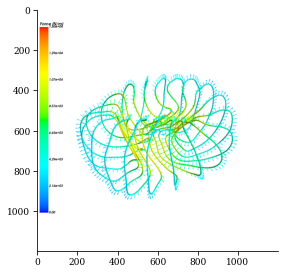

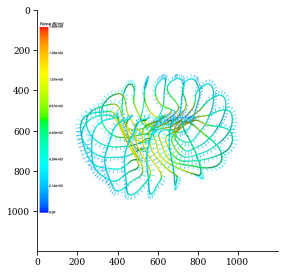

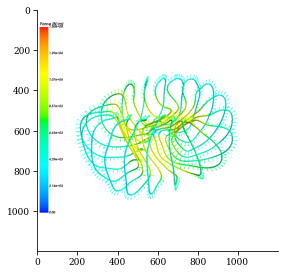

In [12]:
UUID = np.array(df_pareto_final['UUID'])[5]
path = "./output/QA/4/optimizations/" + UUID + "/biot_savart.json"
mlab.options.offscreen = True
for arrow in ["mutual", "self", "force"]:
    arr = plot_coils(path, arrow=arrow)
    mlab.close()
    plt.imshow(arr)
    plt.show()

Finally, we can animate the coils as we move in parameter space along the Pareto front! 

In [13]:
for UUID in df_pareto_final['UUID']:
    in_path = "./output/QA/4/optimizations/" + UUID + "/biot_savart.json"
    out_path = "./output/QA/4/optimizations/" + UUID + "/coils.jpg" 
    plot_coils(in_path)
    mlab.savefig(filename=out_path)   
    mlab.close()

import imageio

sorted_pareto = df_pareto_final.sort_values(by=["max_forces"], ascending=False)
images = []
for UUID in sorted_pareto['UUID']:
    path = "./output/QA/4/optimizations/" + UUID + "/coils.jpg"    
    images.append(imageio.imread(path))
imageio.mimsave('./output/QA/4/QA_pareto_coils.gif', images)

Context leak detected, msgtracer returned -1
Context leak detected, msgtracer returned -1
Context leak detected, msgtracer returned -1
Context leak detected, msgtracer returned -1


KeyboardInterrupt: 

We can also perform a rotating animation of the coils. Here we choose a coil far to the left of the Pareto front and one far to the right.

In [14]:
import imageio
import os

mlab.options.offscreen = True
for arrow in ["total", "self", "mutual"]:
    UUIDs = ["6266c8d4bb25499b899d86e9e3dd2ee2", "c3c984ea02624607b8a59a9fdf0642dd"]
    for UUID in UUIDs:
        in_path = "./output/QA/4/optimizations/" + UUID + "/biot_savart.json"
        out_path = "./output/QA/4/optimizations/" + UUID + "/coils.jpg" 
        plot_coils(in_path, arrow="force")

        nframes = 160
        filenames = []
        # For some reason, the first frame is darker, so repeat that frame at the end.
        for j in range(nframes + 1):
            mlab.view(azimuth=360.0 * j / nframes, elevation=-52.5 + 7.5 * np.sin(j / nframes * 2 * np.pi), distance=14.00, focalpoint=[0, 0, 0])
            filename = f'temp{j:04}.png'
            mlab.savefig(filename=filename)
            filenames.append(filename)

        import imageio
        # Duration is the number of seconds each frame is shown
        duration = 0.04
        name = f"./output/QA/4/rotating_{arrow}_{UUID}.gif"
        with imageio.get_writer(name, mode='I', duration=duration) as writer:
            for filename in filenames[1:]:
                image = imageio.imread(filename)
                writer.append_data(image)

# Delete the temp files
temps = glob.glob(f"./**/temp*.png", recursive=True) 
for temp in temps: os.remove(temp)


/var/folders/qx/zl9pfmpn3yz5f62mt03d1m5w0000gs/T/ipykernel_45285/3047021756.py:27: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.

Context leak detected, msgtracer returned -1


KeyboardInterrupt: 

## Magnetic Field Analysis



In [ ]:
from analysis_tools import *
from desc.plotting import plot_boozer_surface

In [ ]:
UUIDs = ["6266c8d4bb25499b899d86e9e3dd2ee2", "c3c984ea02624607b8a59a9fdf0642dd"]
for UUID in UUIDs:
    qfm_surf, _, _ = qfm(UUID)
    desc_eq = surf_to_desc(qfm_surf)
    fig, ax = plot_boozer_surface(desc_eq)
    plt.show()

Here, we make Poincare plots of the field.

In [ ]:
for UUID in ['49d67fc2af7e418a95abd1b56613bf03', '13b5e759418c4d29b5b826acc90f5cb9']:
    image = poincare(UUID, OUT_DIR='1/poincare')
    plt.imshow(image)

## Miscellaneous / Testing
### Ensemble of Optimizations

We can also analyze the success of our optimizations in terms of how and how much data was excluded during the filtering step. These plots show histograms of the optimizations with regard to numerous parameters, plotted both before and after filtering.

In [ ]:
success_plt(df, df_filtered).show()

Let's see what a good `dx` is for the continuation method. Here, we see that $dx\leq 0.1$ seems appropriate.

In [ ]:
df2, df_filtered2, df_pareto2 = get_dfs(INPUT_DIR='./output/QA/3/optimizations/')

fig = plt.figure(figsize=(6.5, 8))
color = 'dx'
markersize = 5
plt.rc("font", size=13)
norm = matplotlib.colors.LogNorm(1e-3, 7e-2)

plt.scatter(
    df_filtered2["normalized_BdotN"],
    df_filtered2["max_max_force"],
    c=df_filtered2[color],
    s=markersize,
    label=f'Continuation Method',
    norm=norm
)
plt.colorbar(label=color)
plt.scatter(
    df_pareto["normalized_BdotN"], 
    df_pareto["max_max_force"], 
    marker="+",
    c='black',
    label=f'Original Pareto Front',
)
plt.xlabel(r'$\langle|\mathbf{B}\cdot\mathbf{n}|\rangle/\langle B \rangle$ [unitless]')
plt.ylabel("max force [N/m]")
plt.xlim(0.7 * min(df_filtered2["normalized_BdotN"]), max(df_filtered2["normalized_BdotN"]))
plt.ylim(8500, 18000)
plt.xscale("log")
plt.legend(loc='upper right', fontsize='11')
plt.show()